# 目标检测数据集

为了快速测试目标检测模型，我们收集并标记了一个小型数据集。 首先，我们拍摄了一组香蕉的照片，并生成了1000张不同角度和大小的香蕉图像。 然后，我们在一些背景图片的随机位置上放一张香蕉的图像。 最后，我们在图片上为这些香蕉标记了边界框。

## 1. 下载数据集

In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

ModuleNotFoundError: No module named 'matplotlib'

## 2. 读取数据集

通过read_data_bananas函数，我们读取香蕉检测数据集。 该数据集包括一个的CSV文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。

In [138]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

通过使用read_data_bananas函数读取图像和标签，以下BananasDataset类别将允许我们创建一个自定义Dataset实例来加载香蕉检测数据集。

In [139]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float() / 255, self.labels[idx])

    def __len__(self):
        return len(self.features)

最后，我们定义load_data_bananas函数，来为训练集和测试集返回两个数据加载器实例。对于测试集，无须按随机顺序读取它。

In [140]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

让我们读取一个小批量，并打印其中的图像和标签的形状。 图像的小批量的形状为（批量大小、通道数、高度、宽度），看起来很眼熟：它与我们之前图像分类任务中的相同。 标签的小批量的形状为（批量大小，m，5），其中m是数据集的任何图像中边界框可能出现的最大数量。

In [141]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## 3. 演示

让我们展示10幅带有真实边界框的图像。 我们可以看到在所有这些图像中香蕉的旋转角度、大小和位置都有所不同。 当然，这只是一个简单的人工数据集，实践中真实世界的数据集通常要复杂得多。

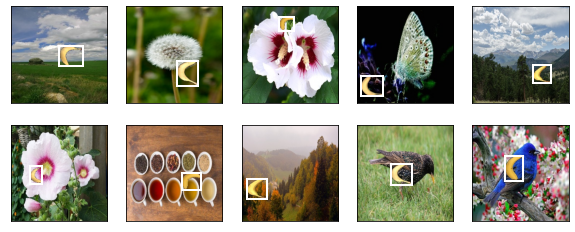

In [146]:
imgs = [torchvision.transforms.ToPILImage()(batch[0][i]) for i in range(10)]
# 或者可以 
# imgs = batch[0][0:10].permute(0, 2, 3, 1)
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])